In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Set a benchmark model and test models without seasonal decomposition

In [2]:
filepath = '../../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_493_m_0_sm_n_t_20200206_193734.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8630 entries, 2016-01-01 23:00:00 to 2016-12-31 23:00:00
Data columns (total 7 columns):
day_of_week               8630 non-null int64
day_hour                  8630 non-null int64
dew_temperature_ma_24H    8630 non-null float64
dew_temperature           8630 non-null float64
air_temperature_ma_24H    8630 non-null float64
air_temperature           8630 non-null float64
meter_reading             8630 non-null float64
dtypes: float64(5), int64(2)
memory usage: 539.4 KB


In [3]:
df_features.head()

,day_of_week,day_hour,dew_temperature_ma_24H,dew_temperature,air_temperature_ma_24H,air_temperature,meter_reading
timestamp,,,,,,,
2016-01-01 23:00:00,4,23,-0.650000,-3.9,6.679167,5.0,316.17
2016-01-02 00:00:00,5,0,-0.925000,-4.4,6.445833,4.4,297.51
2016-01-02 01:00:00,5,1,-1.250000,-5.0,6.216667,3.9,294.78
2016-01-02 02:00:00,5,2,-1.575000,-5.6,6.008333,3.9,296.94
2016-01-02 03:00:00,5,3,-1.854167,-5.6,5.820833,3.3,294.63


In [4]:
target_variables = set(['meter_reading'])
features_variables = set(df_features.columns.to_list())-target_variables
time_variables = set(['day_hour', 'day_of_week'])
meteorological_variables = features_variables - time_variables

print(target_variables)
print(features_variables)
print(time_variables)
print(meteorological_variables)

{'meter_reading'}
{'air_temperature', 'dew_temperature', 'day_of_week', 'day_hour', 'air_temperature_ma_24H', 'dew_temperature_ma_24H'}
{'day_of_week', 'day_hour'}
{'air_temperature_ma_24H', 'air_temperature', 'dew_temperature_ma_24H', 'dew_temperature'}


In [5]:
#y_meter_trend = df_features['meter_reading']
#y_meter_seasonal = df_features['meter_reading_seasonal']
#y_meter_deseasoned = df_features['meter_reading_deseasoned']
Ys_meter = df_features[target_variables]

X_meter = df_features.loc[:, features_variables]
#X_meter_with_day_hour = df_features.loc[:, meteorological_variables.union(set(['day_hour']))]
print('X_meter.shape = {}, Ys_meter.shape = {}'.format(X_meter.shape, Ys_meter.shape))

X_meter.shape = (8630, 6), Ys_meter.shape = (8630, 1)


In [6]:
X_meter.columns

Index(['air_temperature', 'dew_temperature', 'day_of_week', 'day_hour',
       'air_temperature_ma_24H', 'dew_temperature_ma_24H'],
      dtype='object')

In [7]:
# GapKFold
# gap ~ two weeks, train = 1 month (12 folds)

gap = 24*7*2
gap_kf = GapKFold(n_splits=12, gap_before=gap, gap_after=gap)

Let's build a mean value estimator.

From https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py

check_array and check_X_y

https://github.com/scikit-learn/scikit-learn/blob/e5698bde9/sklearn/utils/validation.py#L904

In [8]:
# Actually we don't need that because it already exists in sklearn, under the name 'dummyRegressor'
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [9]:
Ys_meter['meter_reading'].mean()

385.1058563151796

In [10]:
cross_val_score(
    estimator=DummyRegressor(strategy="mean"),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.08954649939541925

In [11]:
cross_val_score(
    estimator=DummyRegressor(strategy="median"),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.08814968102089478

In [12]:
# Now let's take the mean by hour

In [13]:
class MeanByCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_idx=0, verbose=False):
        self.verbose = verbose
        self.cat_column_idx= cat_column_idx

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        if(self.cat_column_idx >= X.shape[1]):
             raise ValueError("category column index should be < X.shape[1]")
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in np.unique(X[:, self.cat_column_idx]):
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            categories[X[k, self.cat_column_idx]].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        for sample_cat in X[:, self.cat_column_idx]:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        return np.array(predictions)

In [14]:
day_hour_col_idx = X_meter.columns.to_list().index('day_hour')

cross_val_score(
    estimator=MeanByCatEstimator(cat_column_idx=day_hour_col_idx),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.057229134217055444

In [15]:
class MeanByMultiCatEstimator(BaseEstimator):
    """ A template estimator to be used as a reference implementation.
    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.
    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """
    def __init__(self, cat_column_indexes=[0], verbose=False):
        self.verbose = verbose
        self.cat_column_indexes = cat_column_indexes

    def fit(self, X, y):
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        
        X, y = check_X_y(X, y, accept_sparse=True)
        """Input validation for standard estimators.
        Checks X and y for consistent length, enforces X to be 2D and y 1D. By
        default, X is checked to be non-empty and containing only finite values.
        Standard input checks are also applied to y, such as checking that y
        does not have np.nan or np.inf targets. For multi-label y, set
        multi_output=True to allow 2D and sparse y. If the dtype of X is
        object, attempt converting to float, raising on failure.
        """
        
        
        cat_columns = []
        
        for col_idx in self.cat_column_indexes:
            if(col_idx >= X.shape[1]):
                raise ValueError("category column indexes should be < X.shape[1]")
            cat_columns.append(X[:, col_idx])
            
        cat_tuples = set(zip(*cat_columns))
        
        categories = {}
        self.means = {}
        
        self.mean = y.mean()
        
        for x_bin in cat_tuples:
            categories[x_bin] = []
            
        if self.verbose:    
            print('categories : {}'.format(categories.keys()))
            
        for k in range(X.shape[0]):
            sample_bin = tuple(X[k, self.cat_column_indexes])
            categories[sample_bin].append(y[k])
        
        for k, v in categories.items():
            self.means[k] = np.array(v).mean()
        
        self.is_fitted_ = True
        # `fit` should always return `self`
        
        if self.verbose:
            for k, v in self.means.items():
                print('({}, {})'.format(k, v))
        
        return self

    
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns an array of ones.
        """
        
        
        X = check_array(X, accept_sparse=True)
        """Input validation on an array, list, sparse matrix or similar.
        By default, the input is checked to be a non-empty 2D array containing
        only finite values. If the dtype of the array is object, attempt
        converting to float, raising on failure."""
        
        check_is_fitted(self, 'is_fitted_')
        
        predictions = []
        
        
        cat_columns=[]
        for col in self.cat_column_indexes:
            cat_columns.append(X[:, col])
            
        cat_tuples = list(zip(*cat_columns))
        
        
        
        for sample_cat in cat_tuples:
            cat_mean = self.means.get(sample_cat)
            if(cat_mean == None):
                predictions.append(self.mean)
            else:
                predictions.append(cat_mean)
            
        
        
        return np.array(predictions)

In [16]:
day_hour_col_idx = X_meter.columns.to_list().index('day_hour')
day_of_week_col_idx = X_meter.columns.to_list().index('day_of_week')
time_col_indexes = [day_hour_col_idx, day_of_week_col_idx]

In [17]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(time_col_indexes),
    X=X_meter,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.04736516532698587

Build a benchmark wich computes means but switch regime when temperature is higher.

In [18]:
min_T_limit = np.floor(X_meter['air_temperature_ma_24H'].min())
max_T_limit = np.ceil(X_meter['air_temperature_ma_24H'].max())

bins_T = [min_T_limit, 0, 10, 20, max_T_limit]
bins_T_labels = [0, 1, 2, 3]

X_meter_w_temperature_bins = X_meter.copy()
X_meter_w_temperature_bins['temperature_bin'] = pd.cut(
    X_meter['air_temperature_ma_24H'], 
    bins=bins_T, 
    labels=bins_T_labels
)

In [19]:
day_hour_col_idx = X_meter_w_temperature_bins.columns.to_list().index('day_hour')
temperature_bin_col_idx = X_meter_w_temperature_bins.columns.to_list().index('temperature_bin')
cat_col_indexes = [day_hour_col_idx, temperature_bin_col_idx]

In [20]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(cat_col_indexes),
    X=X_meter_w_temperature_bins,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.04598942675229417

In [21]:
day_hour_col_idx = X_meter_w_temperature_bins.columns.to_list().index('day_hour')
day_of_week_col_idx = X_meter.columns.to_list().index('day_of_week')
temperature_bin_col_idx = X_meter_w_temperature_bins.columns.to_list().index('temperature_bin')
cat_col_indexes = [day_hour_col_idx, day_of_week_col_idx, temperature_bin_col_idx]

In [22]:
cross_val_score(
    estimator=MeanByMultiCatEstimator(cat_col_indexes),
    X=X_meter_w_temperature_bins,
    y=Ys_meter['meter_reading'],
    scoring='neg_mean_squared_log_error',
    cv=gap_kf).mean()

-0.03926845419310517

Visualize benchmark predictions

In [23]:
benchmark_preds = cross_val_predict(
    estimator=MeanByMultiCatEstimator(cat_col_indexes),
    X=X_meter_w_temperature_bins,
    y=Ys_meter['meter_reading'],
    cv=gap_kf
)

preds_df = pd.DataFrame(index=X_meter.index)
preds_df['target'] = Ys_meter['meter_reading']
preds_df['benchmark_preds'] = benchmark_preds

preds_df_melt = pd.melt(
    preds_df.reset_index(inplace=False),
    id_vars='timestamp', 
    var_name='component', 
    value_name = 'reading'
)

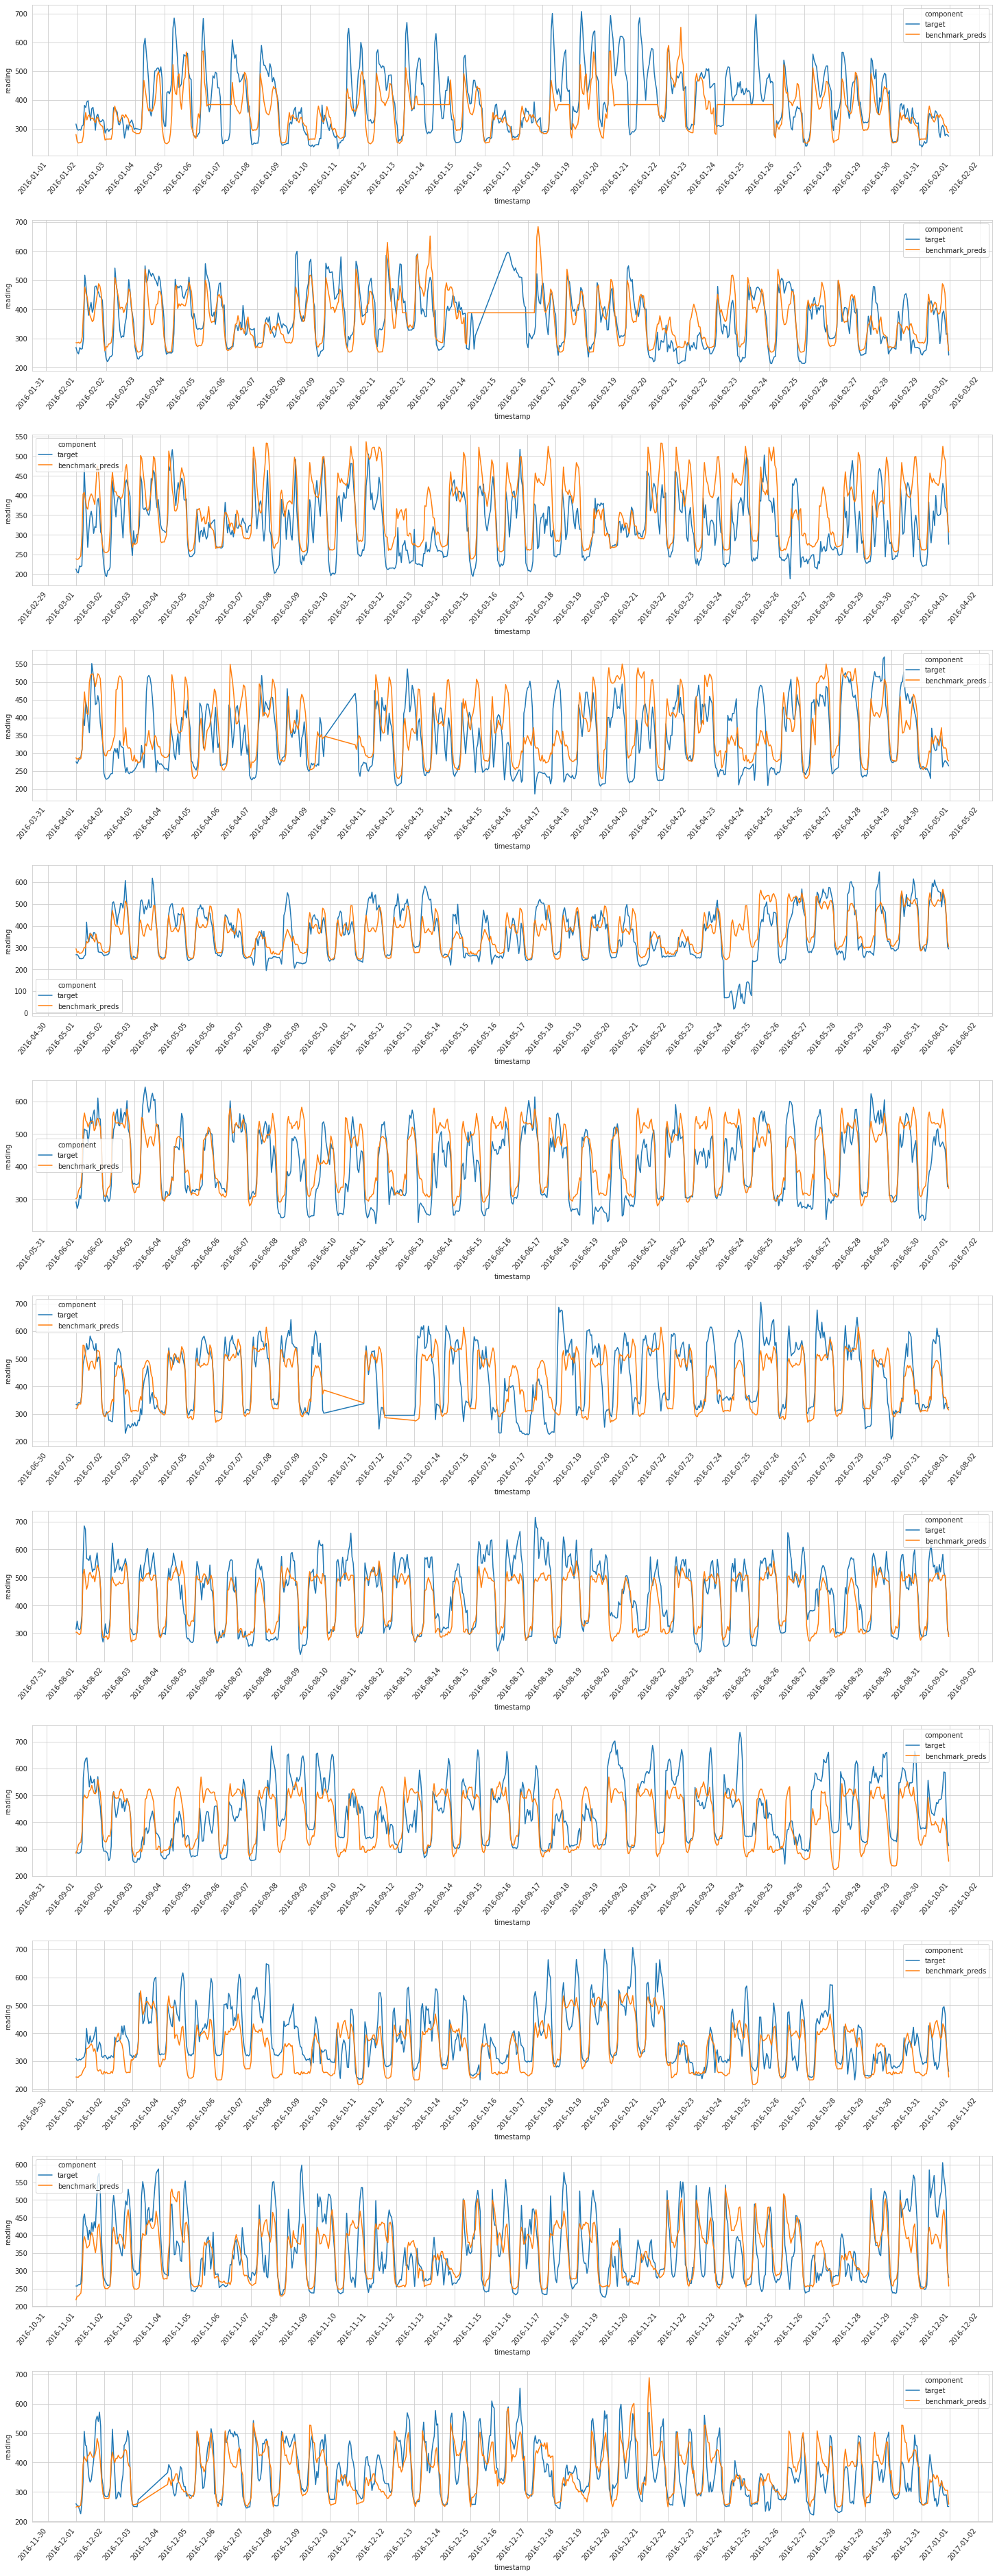

In [24]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    

<b>Random forest model</b>

In [25]:
trendRFR = RandomForestRegressor()

pipe = make_pipeline(trendRFR)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestregressor', 'randomforestregressor__bootstrap', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [26]:
rfr_grid_params = {
    'randomforestregressor__n_estimators' : [50, 100],
    'randomforestregressor__max_features' : ['auto']
}

rfr_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=rfr_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

rfr_CV.fit(X_meter, Ys_meter['meter_reading'])

print('best_params : {}'.format(rfr_CV.best_params_))
print('best_score : {}'.format(rfr_CV.best_score_))

best_params : {'randomforestregressor__max_features': 'auto', 'randomforestregressor__n_estimators': 50}
best_score : -0.03910996217858909


In [27]:
X_meter.head()

,air_temperature,dew_temperature,day_of_week,day_hour,air_temperature_ma_24H,dew_temperature_ma_24H
timestamp,,,,,,
2016-01-01 23:00:00,5.0,-3.9,4,23,6.679167,-0.650000
2016-01-02 00:00:00,4.4,-4.4,5,0,6.445833,-0.925000
2016-01-02 01:00:00,3.9,-5.0,5,1,6.216667,-1.250000
2016-01-02 02:00:00,3.9,-5.6,5,2,6.008333,-1.575000
2016-01-02 03:00:00,3.3,-5.6,5,3,5.820833,-1.854167


In [34]:
Ys_meter['meter_reading'].head()

timestamp
2016-01-01 23:00:00    316.17
2016-01-02 00:00:00    297.51
2016-01-02 01:00:00    294.78
2016-01-02 02:00:00    296.94
2016-01-02 03:00:00    294.63
Name: meter_reading, dtype: float64

In [28]:
bench_rfr = RandomForestRegressor()

pipe = make_pipeline(bench_rfr)

rfr_grid_params = {
    'randomforestregressor__n_estimators' : [10, 25, 50, 75, 100, 125, 150, 200],
    'randomforestregressor__max_features' : ['auto', 'sqrt'],
    'randomforestregressor__max_depth' : [4, 6, 8, 10, 12, 20, 40]
}

rfr_CV = GridSearchCV(
    estimator=pipe, 
    param_grid=rfr_grid_params,
    scoring='neg_mean_squared_log_error',
    cv=gap_kf
)

rfr_CV.fit(X_meter, Ys_meter['meter_reading'])

print('best_params : {}'.format(rfr_CV.best_params_))
print('best_score : {}'.format(rfr_CV.best_score_))

best_params : {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__n_estimators': 100}
best_score : -0.03582104909542987


In [29]:
pipe.named_steps

{'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}

In [30]:
pipe['randomforestregressor']

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [31]:
# Feature importance

rfr_best_estimator=rfr_CV.best_estimator_['randomforestregressor']
#rfr_estimator.fit(X=X_meter, y=Ys_meter['meter_reading'])

named_feature_importance = zip(X_meter.columns.to_list(), rfr_best_estimator.feature_importances_.tolist())

feature_importance_df = pd.DataFrame(named_feature_importance, columns=['feature', 'importance_score'])
feature_importance_df.set_index('feature', inplace=True)
feature_importance_df.sort_values(by='importance_score', ascending=False, inplace=True)
feature_importance_df

,importance_score
feature,
day_hour,0.518058
dew_temperature,0.118859
day_of_week,0.116767
dew_temperature_ma_24H,0.108717
air_temperature_ma_24H,0.083471
air_temperature,0.054128


In [32]:
benchmark_preds = cross_val_predict(
    estimator=rfr_best_estimator,
    X=X_meter,
    y=Ys_meter['meter_reading'],
    cv=gap_kf
)

preds_df = pd.DataFrame(index=X_meter.index)
preds_df['target'] = Ys_meter['meter_reading']
preds_df['benchmark_preds'] = benchmark_preds

preds_df_melt = pd.melt(
    preds_df.reset_index(inplace=False),
    id_vars='timestamp', 
    var_name='component', 
    value_name = 'reading'
)

preds_df_melt.head()

,timestamp,component,reading
0,2016-01-01 23:00:00,target,316.17
1,2016-01-02 00:00:00,target,297.51
2,2016-01-02 01:00:00,target,294.78
3,2016-01-02 02:00:00,target,296.94
4,2016-01-02 03:00:00,target,294.63


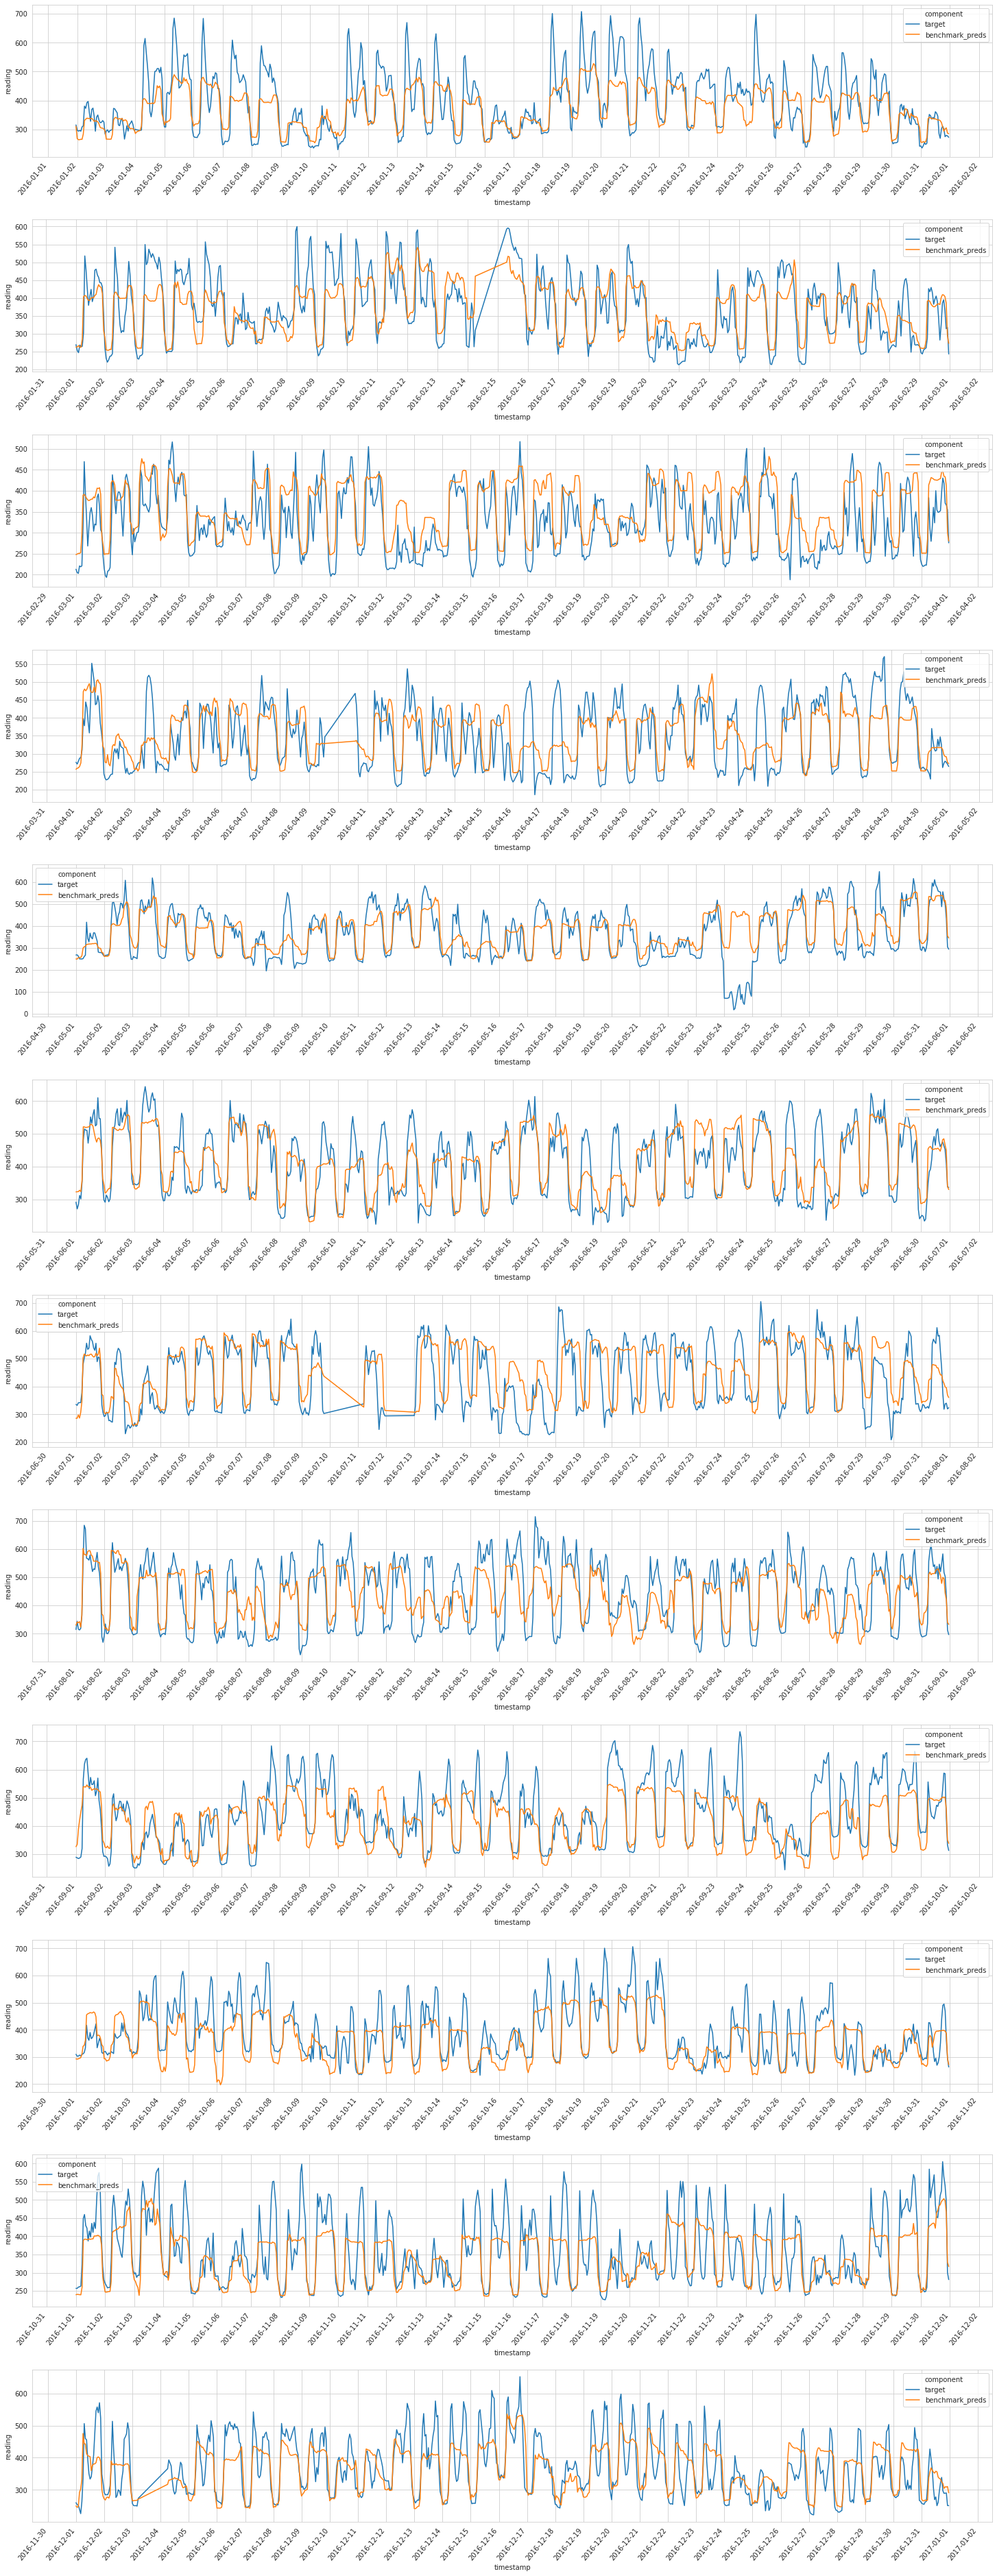

In [33]:
# Plot month by month

date_range = pd.date_range(start=X_meter.index.min()-pd.Timedelta('1 days'), 
                           end=X_meter.index.max(), freq='1M')

fig = plt.figure(figsize=(20, 4*date_range.shape[0]))

restrict_df_to_dates = lambda df, d1, d2 : df[(df['timestamp'] > d1) & (df['timestamp'] <= d2)]


with sns.axes_style("whitegrid"):
    for i in range(date_range.shape[0]-1) :
        plt.subplot(12,1,i+1)
        start_date = date_range[i]
        end_date = date_range[i+1]
        data = restrict_df_to_dates(preds_df_melt, start_date, end_date)
        ax = sns.lineplot(x="timestamp", y="reading", hue="component", data=data)
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=50, horizontalalignment='right')
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)    